We use gradient descent with backtracking.
See Nocedal, Wright: pg 37.

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import numpy.random as rnd

In [3]:
import itertools as itt

In [4]:
import pandas as pd
from pandas import Series, DataFrame

In [5]:
from IPython.display import display

In [6]:
from collections import OrderedDict

In [7]:
import matplotlib.pyplot as pl
%matplotlib inline

# Define the variable and the function

In [8]:
floatX = np.float32

In [9]:
sess = tf.InteractiveSession()

In [10]:
x = tf.Variable(
    np.ones(shape = [4, 2]), 
    name = "x", dtype = floatX,
)
sess.run(x.initializer)

In [11]:
x_min = np.array([
    [0, 0],
    [3, 3],
    [3, 0],
    [0, 3],
], dtype = floatX)

In [12]:
def fun(x, name = "fun"):
    return tf.reduce_sum((x - x_min)**2, axis = -1, name = name)

In [13]:
f = fun(x, name = "f")

In [14]:
df = tf.gradients(f, x)[0]

In [15]:
def plot_f_and_x(f, x, xxx = np.linspace(-5, 5, 30), yyy = None):
    ## plot f
    if yyy is None:
        yyy = xxx
        
    N, dim = sess.run(x).shape
    assert dim == 2
    
    vals = np.empty([N, len(xxx), len(yyy)])
    for i, xx in enumerate(xxx):
        for j, yy in enumerate(yyy):
            vals[:, i, j] = sess.run(f, {x: np.ones([N, 1]) * [xx,yy]})
        
    columns = 2
    rows = int(np.ceil(N / columns))
    fig, axs = pl.subplots(rows, columns, figsize = [columns * 4, rows * 4])
    
    for val, ax in zip(vals, axs.flat):
        ax.pcolormesh(xxx, yyy, val.T)
        
    ## plot x
    for ax, xx in zip(axs.flat, sess.run(x)):
        ax.scatter(*xx)

    return axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A019A7DDD8>,
      dtype=object)

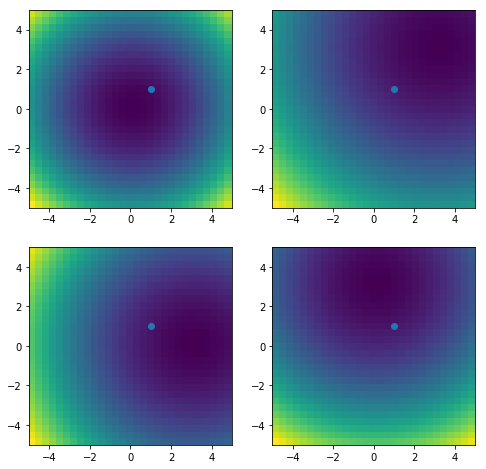

In [16]:
plot_f_and_x(f, x)

# Optimize with gradient descent

In [17]:
from pitrain.gradient_descent_with_backtracking import GragientDescentWithBacktracking

In [18]:
optimizer = GragientDescentWithBacktracking.from_scratch(x = x, f = f, df = df, name = "grad_desc")
#     optimizer.initializer = optimizer.construct_initializer(initial_step_length=1)
#     optimizer.step_sequence = optimizer.construct_step_sequence()

In [27]:
sess.run(x.initializer)
optimizer.run_initializer()
print(sess.run(f))

[2. 8. 5. 5.]


[1.0831864e-04 2.4397822e-01 4.3594204e-02 4.3594204e-02]


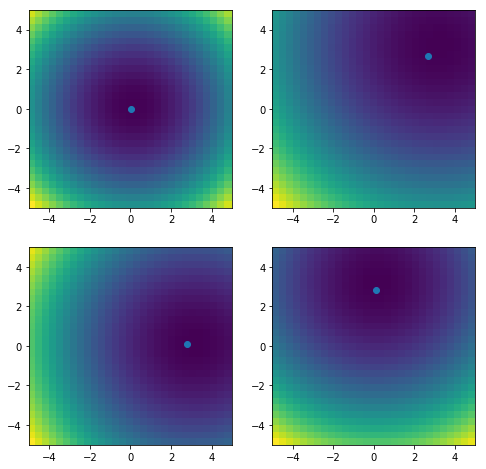

In [31]:
optimizer.run_train_step()
plot_f_and_x(f, x)
print(sess.run(f))

### Restore the optimizer from the graph

In [32]:
opt2 = GragientDescentWithBacktracking.find_in_graph("grad_desc")

In [33]:
opt2.run_initializer()

In [34]:
sess.run(x.initializer)
opt2.run_initializer()
print(sess.run(f))

[2. 8. 5. 5.]


In [35]:
opt2.run_train_step()
#plot_f_and_x(f, x)
print(sess.run(f))

[0.1715729 3.3431456 1.527864  1.527864 ]


# Brute Froce

In [38]:
from pitrain.brute_force_optimization import BruteForceOptimization

In [39]:
brute = BruteForceOptimization.from_scratch(f, x, name = "brute")

In [40]:
sess.run(x.initializer)
brute.run_initializer()

xxx = np.mgrid[-4:4:5j, -4:4:5j].reshape(2, -1).T

print(sess.run(f))
for x_prop in xxx:
    brute.run_train_step(x_prop)
print(sess.run([f, x]))


[2. 8. 5. 5.]
[array([0., 2., 1., 1.], dtype=float32), array([[0., 0.],
       [2., 2.],
       [2., 0.],
       [0., 2.]], dtype=float32)]


### Restore the optimizer from the graph

In [41]:
brute2 = BruteForceOptimization.find_in_graph("brute")

In [42]:
brute2

In [43]:
sess.run(x.initializer)
brute2.run_initializer()

xxx = np.mgrid[-4:4:5j, -4:4:5j].reshape(2, -1).T

print(sess.run(f))
for x_prop in xxx:
    brute2.run_train_step(x_prop)
print(sess.run([f, x]))


[2. 8. 5. 5.]
[array([0., 2., 1., 1.], dtype=float32), array([[0., 0.],
       [2., 2.],
       [2., 0.],
       [0., 2.]], dtype=float32)]


# Saving and restoring model with optimizers

## Save model

In [45]:
out_dir = r"D:\tmp\saved_model_test_01"
builder = tf.saved_model.builder.SavedModelBuilder(out_dir)
builder.add_meta_graph_and_variables(sess, tags = [tf.saved_model.tag_constants.SERVING])
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: D:\tmp\saved_model_test_01\saved_model.pb


b'D:\\tmp\\saved_model_test_01\\saved_model.pb'

## Load

In [46]:
tf.reset_default_graph()

sess.close()
sess = tf.InteractiveSession()

In [47]:
tf.saved_model.loader.load(sess, tags = [tf.saved_model.tag_constants.SERVING], export_dir=out_dir);

INFO:tensorflow:Restoring parameters from D:\tmp\saved_model_test_01\variables\variables


## Find model in loaded graph

In [48]:
gr = tf.get_default_graph()

x = gr.get_tensor_by_name("x:0")
x.initializer = gr.get_operation_by_name("x/Assign")

f = gr.get_tensor_by_name("f:0")

In [49]:
brute = BruteForceOptimization.find_in_graph("brute")

In [50]:
grad_desc = GragientDescentWithBacktracking.find_in_graph("grad_desc")

## Run it

In [51]:
sess.run(x.initializer)
sess.run(f)

array([2., 8., 5., 5.], dtype=float32)

In [52]:
## Brute optimization
brute.run_initializer()
for x_prop in xxx:
    brute.run_train_step(x_prop)
    
print(sess.run(f))

[0. 2. 1. 1.]


In [53]:
## Gradient descent
grad_desc.run_initializer()
for i in range(20):
    grad_desc.run_train_step()
   
print(sess.run(f))

[0.000000e+00 5.858169e-09 0.000000e+00 0.000000e+00]
